## Import package

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from sklearn.decomposition import PCA
import lightgbm as lgb

In [4]:
df = pd.read_csv('../input/df_feature.csv')
df = df.drop(columns=['bookingID'],axis=1)

## Correlation plot

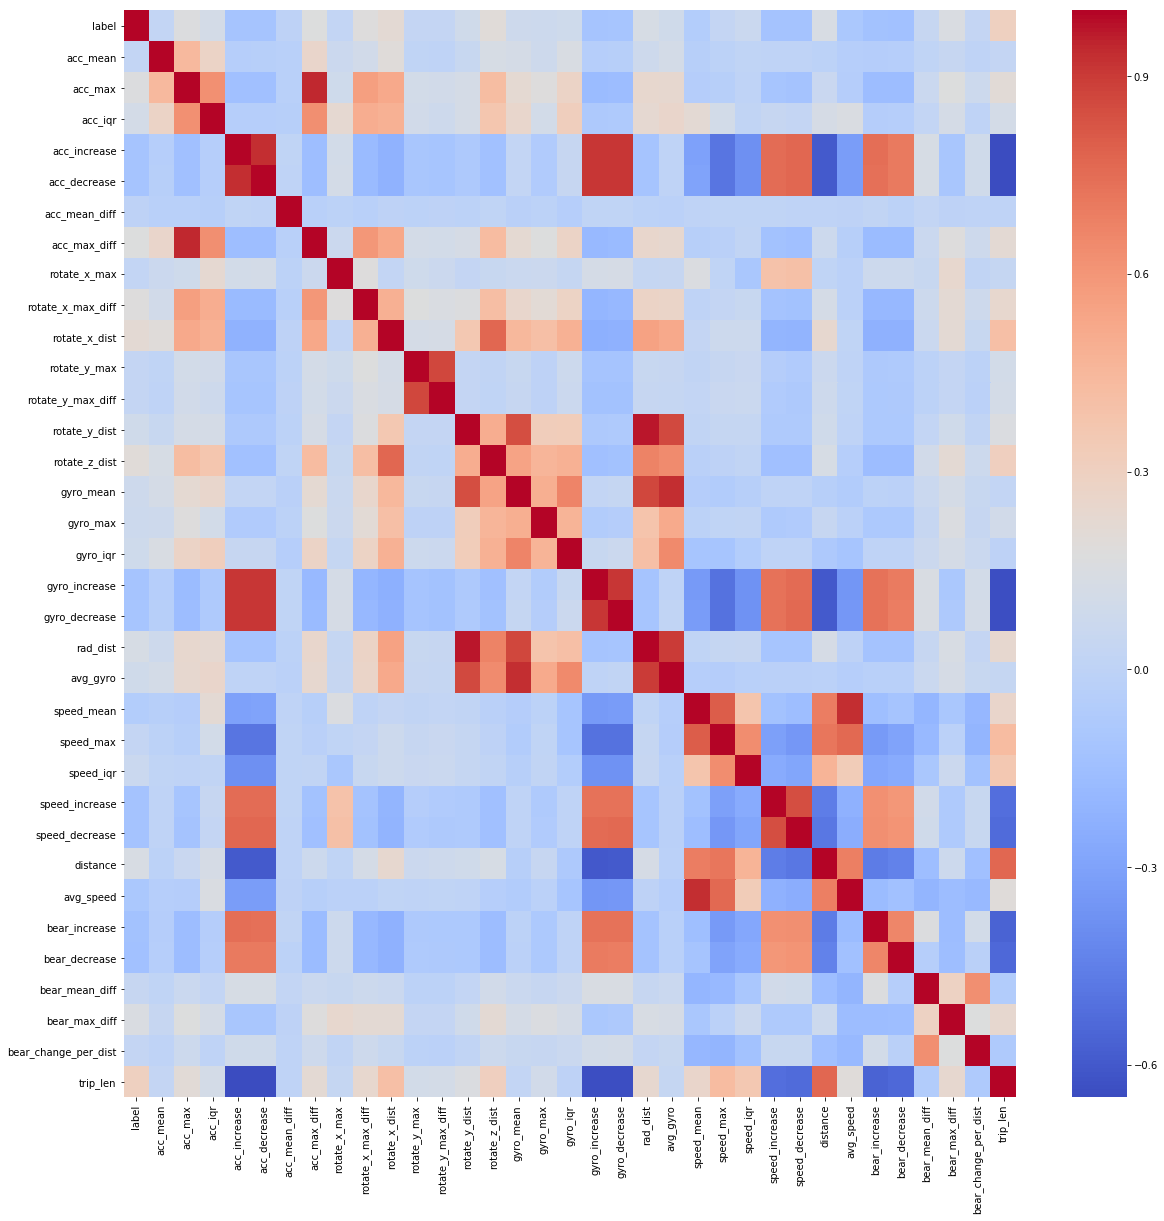

In [5]:
plt.figure(figsize=(20,20))
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap = 'coolwarm')
plt.show()

## Model Training

In [6]:
X = df.drop(columns=['label'],axis=1)
y = df.label
x_train, x_val, y_train, y_val = train_test_split(X,y, stratify = y, random_state = 1, test_size=0.2)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(15949, 34)
(15949,)
(3988, 34)
(3988,)


### XGBoost (raw features)

In [8]:
params_grid = [
    {
        'eta':[0.01,0.05,0.1],
        'min_child_weight':[1,10,100],
        'max_depth':[3,5],
        'subsample':[0.5,0.7,0.9],
        'lambda':[0.01,0.1,1],
        'objective':['binary:logistic'],
        'eval_metric':['auc'],
        'seed':[42]
    }
]

In [9]:
xgb = XGBClassifier()
grid_search = GridSearchCV(xgb, params_grid, cv = 5, n_jobs=-1, verbose=1)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 19.6min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'eta': [0.01, 0.05, 0.1], 'min_child_weight': [1, 10, 100], 'max_depth': [3, 5], 'subsample': [0.5, 0.7, 0.9], 'lambda': [0.01, 0.1, 1], 'objective': ['binary:logistic'], 'eval_metric': ['auc'], 'seed': [42]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [10]:
grid_search.best_score_

0.7801743055990972

In [11]:
grid_search.best_estimator_.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.01, eval_metric='auc', gamma=0,
       lambda=0.01, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=0.5)

In [12]:
best_model = grid_search.best_estimator_
prob = best_model.predict_proba(x_val)[:,1]

print('The validation AUC is :', roc_auc_score(y_val,prob))
fpr, tpr, __ = roc_curve(y_val,prob)

The validation AUC is : 0.7395835114839672


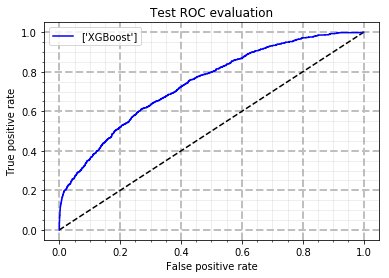

In [13]:
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr,tpr ,label=['XGBoost'],color='blue')
plt.grid(True, lw = 2, ls = '--', c = '.75')
plt.minorticks_on()
plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Test ROC evaluation')
plt.legend(loc='best')
plt.show()

## Final model

In [ ]:
final_model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
colsample_bytree=1, eta=0.01, eval_metric='auc', gamma=0, 
learning_rate=0.1, max_delta_step=0, max_depth=3,
min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
nthread=None, objective='binary:logistic', random_state=0,
reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,subsample=0.5)

In [ ]:
final_model.fit(X,y)

In [ ]:
filename = 'finalized_model.sav' ## Please save to your own directory
pickle.dump(final_model, open(filename, 'wb'))